- Importamos las librerias que vamos a utilizar

In [32]:
import pandas as pd
import numpy as np
import ast
pd.set_option('display.max_columns', None)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns



- Cargamos los data set 


In [33]:

csv_file_path = ("../data/df_movie.csv")
csv_file_path3 = ("../data/df_crew.csv")
csv_file_path2 = ("../data/df_cast.csv")
try:
    df_movie = pd.read_csv(csv_file_path)
    df_cast = pd.read_csv(csv_file_path2)
    df_crew = pd.read_csv(csv_file_path3)
    print("Archivo cargado correctamente.")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo {csv_file_path} y {csv_file_path2}. Verifica la ruta y asegúrate de que el archivo exista.")


Archivo cargado correctamente.


- Combinamos los datos del elenco y los datos del director con el DataFrame principal de películas, añadiendo la información de los tres principales actores y el director a cada registro de película.

In [34]:
#Extraer a los 5 primeros actores de la tabla de cast agrupandolos en una lista 
df_cast['cast'] = df_cast.groupby('id').cumcount() + 1
df_cast_top5 = df_cast[df_cast['cast'] <= 3]
df_cast_top5 = df_cast_top5.groupby('id')['castname'].apply(list).reset_index()
df_cast_top5.columns = ['id', 'top_5_actors']

# Extraer el director
df_directors = df_crew[df_crew['crewjob'] == 'Director']
df_directors = df_directors.groupby('id')['crewname'].first().reset_index()
df_directors.columns = ['id', 'director']

# unir df_movie 
df_modelo = df_movie.merge(df_cast_top5, on='id', how='left')
df_modelo = df_modelo.merge(df_directors, on='id', how='left')



Visualización de Valores Nulos
Para entender la calidad y completitud de nuestros datos, utilizamos la biblioteca missingno para visualizar los valores nulos presentes en nuestro DataFrame. La gráfica de barras muestra la cantidad de valores presentes en cada columna.

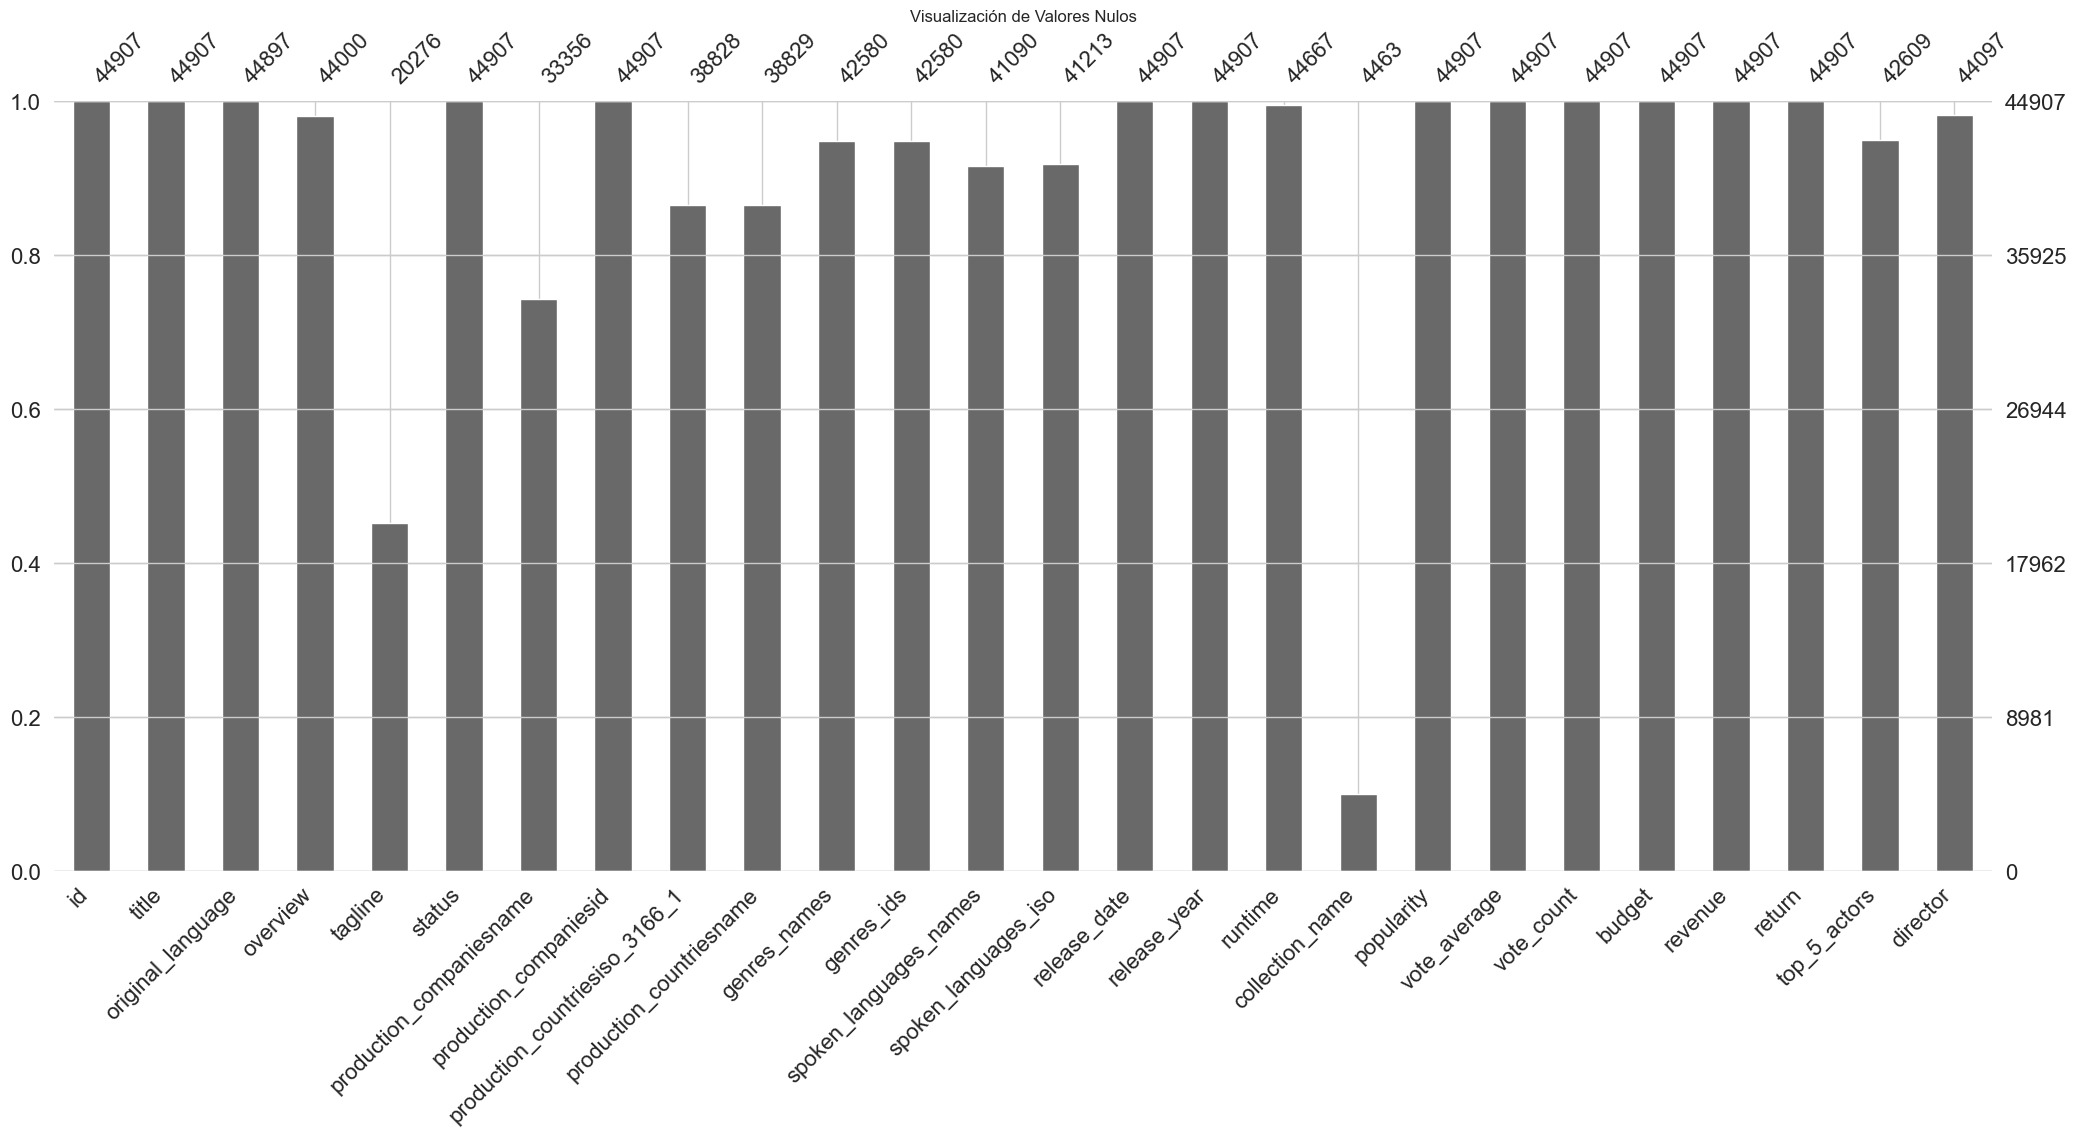

In [35]:
import missingno as msno

# Visualización de valores nulos
plt.figure()
msno.bar(df_modelo)
plt.title('Visualización de Valores Nulos')
plt.show()


Con el objetivo de recortar el dataset para que pudiera ser más consistente en el funcionamiento de nuestra API, se decide recortar el data set haciendo un promedio de los datos vote_average o popularty y dejando solo a los que esten por encima de la media 

- se decide usar vote_average por que tiene menos cantidad de outlayers a simple vista sus datos parecen ser meas consistentes 


- Posteriormente esta medida fue revocada porque al hacer el deployment en render llegaron a entrar 44 mil registros los cuales permitian un mejor rendimiento del sistema de recomendación.

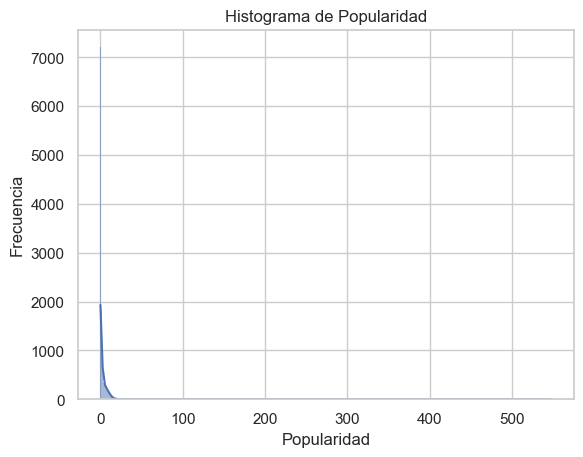

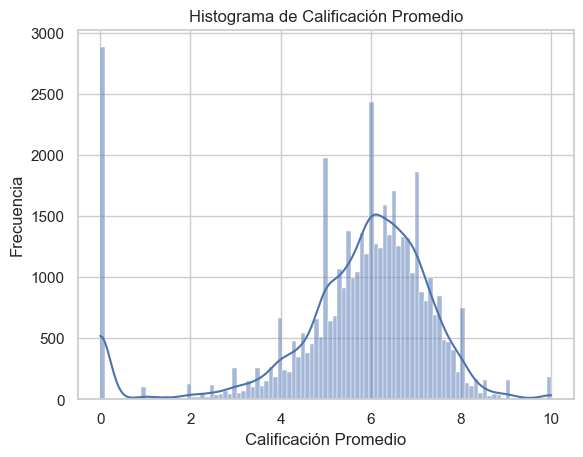

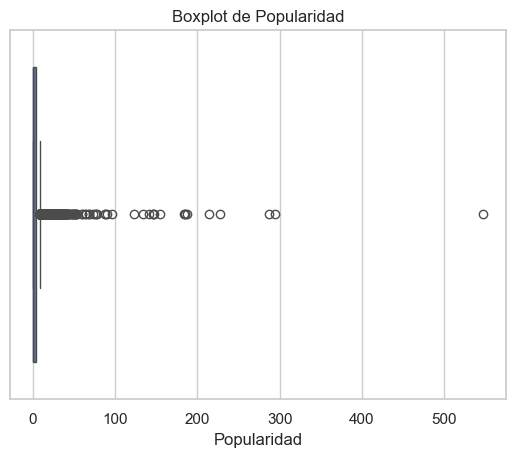

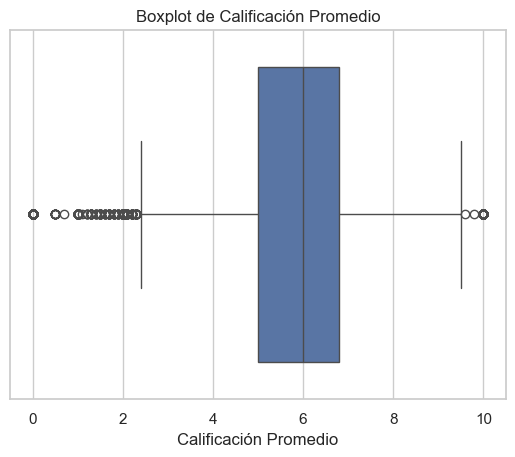

In [36]:


# Ajuste de estilo
sns.set(style="whitegrid")

# Histograma de la columna 'popularity'
plt.figure()
sns.histplot(df_modelo['popularity'], kde=True)
plt.title('Histograma de Popularidad')
plt.xlabel('Popularidad')
plt.ylabel('Frecuencia')
plt.show()

# Histograma de la columna 'vote_average'
plt.figure()
sns.histplot(df_modelo['vote_average'], kde=True)
plt.title('Histograma de Calificación Promedio')
plt.xlabel('Calificación Promedio')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot de la columna 'popularity'
plt.figure()
sns.boxplot(x=df_modelo['popularity'])
plt.title('Boxplot de Popularidad')
plt.xlabel('Popularidad')
plt.show()

# Boxplot de la columna 'vote_average'
plt.figure()
sns.boxplot(x=df_modelo['vote_average'])
plt.title('Boxplot de Calificación Promedio')
plt.xlabel('Calificación Promedio')
plt.show()


Se analiza la cantidad de valores nulos para tomar algunas decisisiones en base a lo que va ser la eleccion del modelo.
- se prioriza overview por sobre tagline 
- production_companiesname, collection_name, tagline cuentan con mas de 10.000 valores nulos por lo que se descarta su uso en el modelo

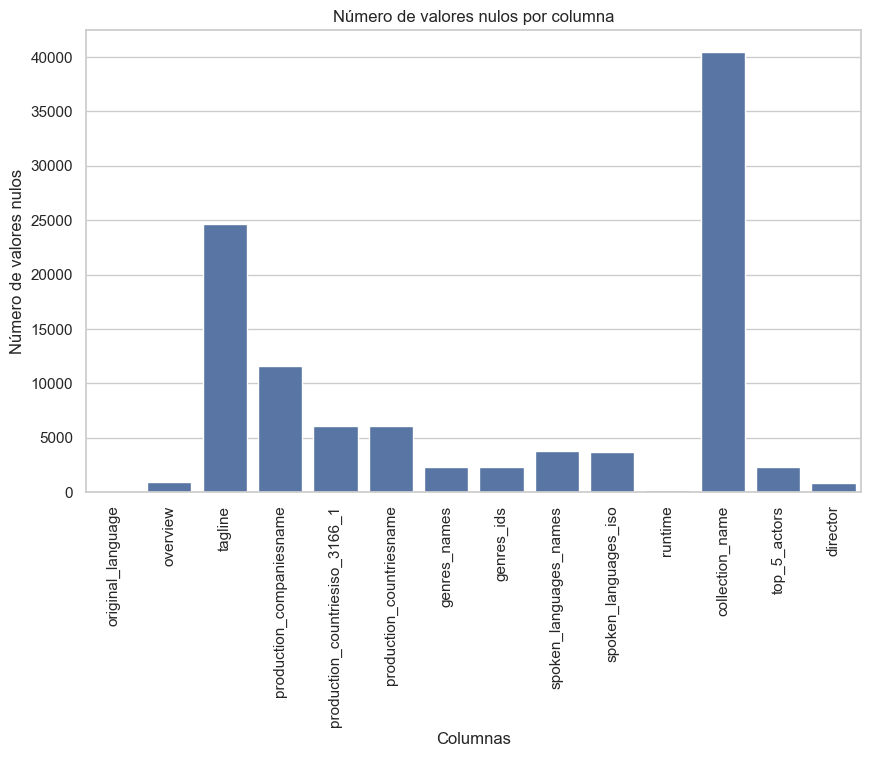

In [37]:

modelnulls = df_modelo.isna().sum()

# Filtrar solo las columnas con valores nulos
modelnulls = modelnulls[modelnulls > 0]

# Crear un gráfico de barras de los valores nulos
plt.figure(figsize=(10, 6))
sns.barplot(x=modelnulls.index, y=modelnulls.values)
plt.xticks(rotation=90)  # Rotar los nombres de las columnas para mejor legibilidad
plt.title('Número de valores nulos por columna')
plt.xlabel('Columnas')
plt.ylabel('Número de valores nulos')
plt.show()


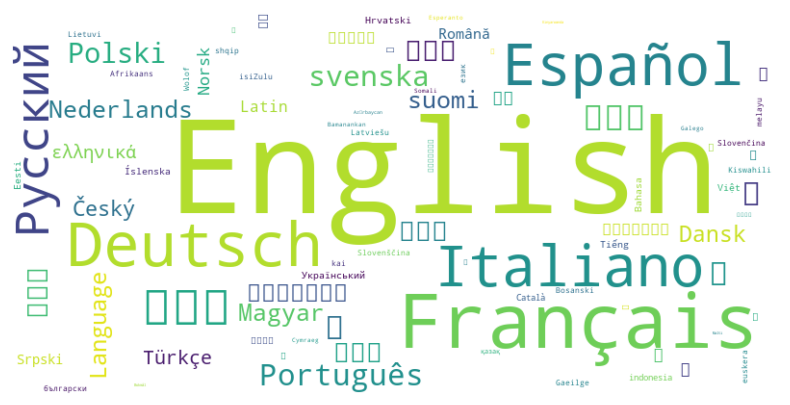

In [38]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Supongamos que df_modelo es el DataFrame que contiene la columna 'spoken_languages_names'
# Aquí cargamos un DataFrame de ejemplo. Asegúrate de reemplazar esto con tu propio DataFrame.
# df_modelo = pd.read_csv('tu_archivo.csv')

# Unir todos los nombres de los idiomas en una sola cadena de texto
text = ' '.join(df_modelo['spoken_languages_names'].dropna().astype(str).tolist())

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Quitar los ejes
plt.show()


- En conclusion se define que utlizaremos el idioma inglés para realizar todos los parametros que tengamos que usar en la normalizacion de datos para la vectorizacion y el uso posterior de la similitud del coseno

In [39]:
df = df_modelo 

- Se observa la cantidad de generos y vemos que predominan 'drama' y 'comedia' por sobre los demás

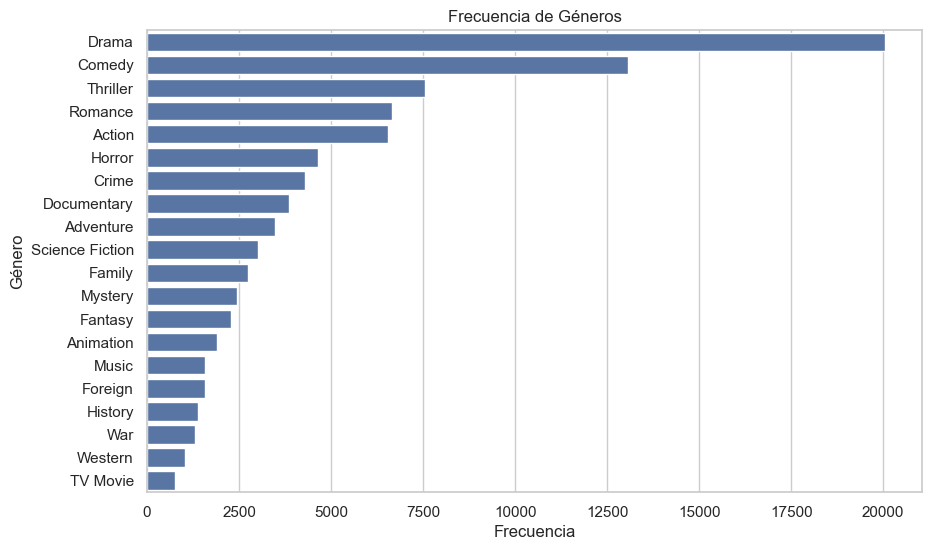

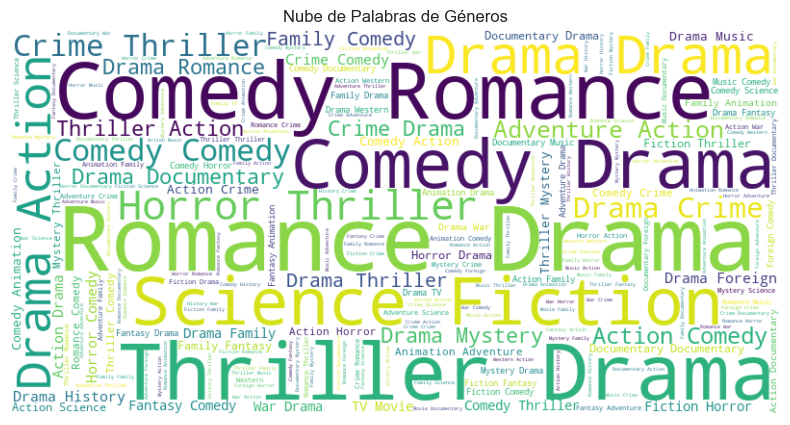

In [40]:
df = df_modelo 
from collections import Counter

genres = df['genres_names'].str.split(', ').explode()
genre_counts = Counter(genres)
genre_df = pd.DataFrame(genre_counts.items(), columns=['Género', 'Frecuencia']).sort_values(by='Frecuencia', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Frecuencia', y='Género', data=genre_df)
plt.title('Frecuencia de Géneros')
plt.xlabel('Frecuencia')
plt.ylabel('Género')
plt.show()

# Nube de Palabras para Géneros
from wordcloud import WordCloud

text_genres = ' '.join(genres.dropna().values)

wordcloud_genres = WordCloud(width=800, height=400, background_color='white').generate(text_genres)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_genres, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras de Géneros')
plt.show()


Se observa que la mayoría de las producciones cinematográficas proceden de Estados Unidos y Reino Unido, lo cual explica la prevalencia del idioma inglés en las películas.








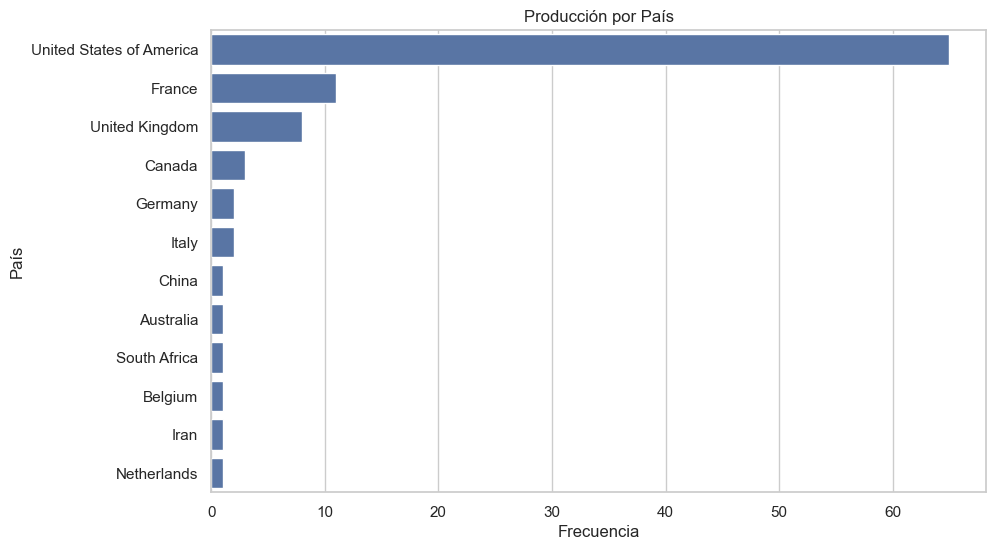

In [41]:
# Producción por País
countries = df['production_countriesname'].str.split(', ').explode().head(100)
country_counts = Counter(countries)
country_df = pd.DataFrame(country_counts.items(), columns=['País', 'Frecuencia']).sort_values(by='Frecuencia', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Frecuencia', y='País', data=country_df)
plt.title('Producción por País')
plt.xlabel('Frecuencia')
plt.ylabel('País')
plt.show()

- Evolución de Budget y Revenue  para analizar como fue la inversion y la ganancia a lo largo de los Años

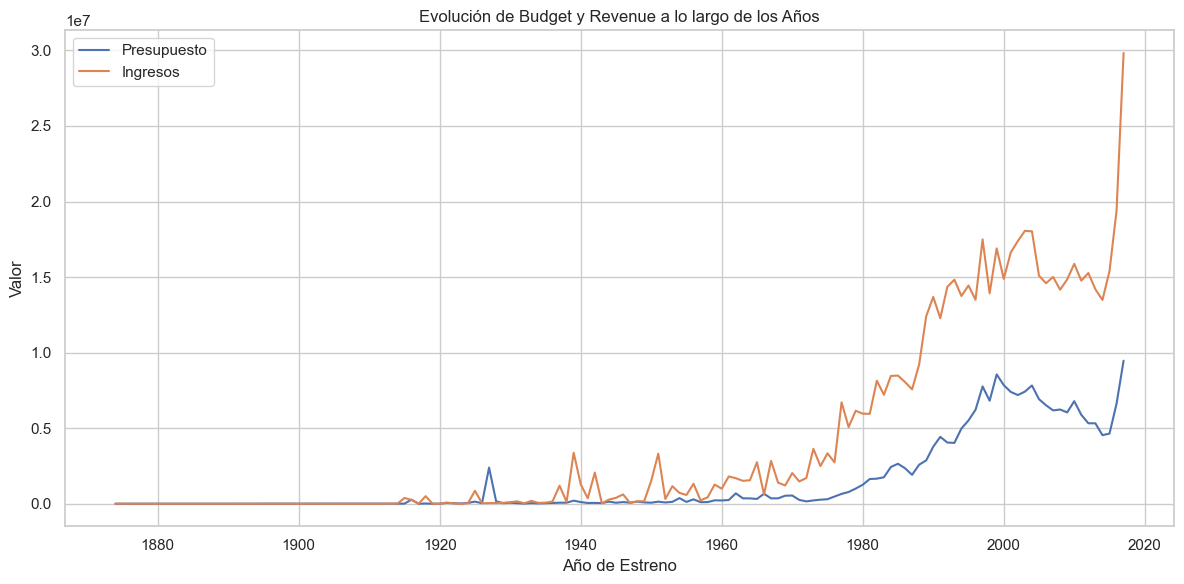

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Filtrar el DataFrame para asegurar que no haya valores nulos en 'release_year', 'budget', y 'revenue'
df_filtered = df.dropna(subset=['release_year', 'budget', 'revenue'])

# Agrupar por release_year y calcular promedios de budget y revenue
temporal_df = df_filtered.groupby('release_year')[['budget', 'revenue']].mean().reset_index()

# Crear el gráfico de línea de budget y revenue
plt.figure(figsize=(12, 6))
sns.lineplot(x='release_year', y='budget', data=temporal_df, label='Presupuesto')
sns.lineplot(x='release_year', y='revenue', data=temporal_df, label='Ingresos')

# Agregar títulos y etiquetas
plt.title('Evolución de Budget y Revenue a lo largo de los Años')
plt.xlabel('Año de Estreno')
plt.ylabel('Valor')
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


### Seleccionamos las columnas importantes para el modelo de recomendación, se consideraron estas columnas contienen la información más relevante para calcular la similitud entre películas.
- title (contiene el titulo de la película)
- overview (contiene una breve descripción)
- genres_name(contiene los géneros)
- top_5_actors (contiene los 5 primeros actores de una película)
- director (contiene el director de la pelicula)

In [43]:
df_modelo = df_modelo[['id','title', 'overview', 'genres_names', 'top_5_actors', 'director']]

- Normalizamos los títulos de las películas a minúsculas para evitar problemas de comparación debido a diferencias de capitalización.
- Unimos los nombres de actores si están en una lista y normalizarlos a minúsculas.
de esta manera nos aseguramos de que todos los nombres de actores se manejen de manera uniforme.

In [44]:
df_modelo['title'] = df_modelo['title'].str.lower()

df_modelo['top_5_actors'] = df_modelo['top_5_actors'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

df_modelo['top_5_actors'] = df_modelo['top_5_actors'].str.lower()



C:\Users\Giova\AppData\Local\Temp\ipykernel_17228\3021171557.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['title'] = df_modelo['title'].str.lower()
C:\Users\Giova\AppData\Local\Temp\ipykernel_17228\3021171557.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['top_5_actors'] = df_modelo['top_5_actors'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
C:\Users\Giova\AppData\Local\Temp\ipykernel_17228\3021171557.py:5: SettingWithCopyWarning: 
A value is trying to be set o

- Descargar stopwords y recursos de tokenización si aún no están descargados.(Las stopwords son palabras comunes que no aportan mucho significado y deben eliminarse para mejorar la precisión del modelo.)

In [45]:

nltk.download('stopwords')
nltk.download('punkt')

stopwords_english = set(stopwords.words('english'))
stopwords_spanish = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Giova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Giova\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


- Función para tokenizar y eliminar stopwords manteniendo nombres completos de actores.
- Esto ayuda a limpiar el texto y a eliminar palabras irrelevantes, mejorando la calidad de la vectorización y la similitud del coseno.

In [46]:

def tokenize_and_remove_stopwords(text, language='english'):
    """
    Preprocesa el texto eliminando signos de puntuación y palabras vacías.

    Parameters:
    texto (str): Texto a preprocesar.

    Returns:
    str: Texto preprocesado.
    """
    tokens = word_tokenize(text)
    if language == 'english':
        tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stopwords_english]
    elif language == 'spanish':
        tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stopwords_spanish]
    return ' '.join(tokens)

In [47]:
def preprocess_columns(df, columns=['overview', 'genres_names', 'top_5_actors', 'director'], language='english'):
    for col in columns:
        df[col] = df[col].apply(lambda x: tokenize_and_remove_stopwords(str(x), language))
    return df

df_modelo = preprocess_columns(df_modelo)

      


C:\Users\Giova\AppData\Local\Temp\ipykernel_17228\602866894.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x: tokenize_and_remove_stopwords(str(x), language))


- Convertir las columnas de géneros, actores y directores a listas.
- Esto facilita la vectorización posterior, ya que podemos tratar cada elemento de la lista como una palabra única.

In [48]:

df_modelo['genres_names'] = df_modelo['genres_names'].apply(lambda x: x.split(', '))
df_modelo['top_5_actors'] = df_modelo['top_5_actors'].apply(lambda x: x.split(', '))
df_modelo['director'] = df_modelo['director'].apply(lambda x: x.split(', '))


C:\Users\Giova\AppData\Local\Temp\ipykernel_17228\3000037161.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['genres_names'] = df_modelo['genres_names'].apply(lambda x: x.split(', '))
C:\Users\Giova\AppData\Local\Temp\ipykernel_17228\3000037161.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo['top_5_actors'] = df_modelo['top_5_actors'].apply(lambda x: x.split(', '))
C:\Users\Giova\AppData\Local\Temp\ipykernel_17228\3000037161.py:3: SettingWithCopyWarning: 
A value is trying to be 

- Rellenar valores nulos con 'Sin dato' para evitar problemas durante la vectorización.

In [49]:
df_modelo.fillna('Sin dato', inplace=True)

C:\Users\Giova\AppData\Local\Temp\ipykernel_17228\3685334694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo.fillna('Sin dato', inplace=True)


- Guardamos el DataFrame preprocesado en un archivo CSV para poder llevarlo a nuestra APP posteriormente

In [50]:
df_modelo.to_csv('../data/df_modelo1.csv', index=False)

##### Para la creacion de nuestro sistema de recomenciones de peliculas utilizaremos dos herramientas
- 1) Vectorización con TfidfVectorizer: Se utilizó para convertir las descripciones de películas, géneros, actores principales y directores en vectores numéricos que representan su contenido de manera cuantitativa.

- 2) Similitud del coseno: Se empleó para calcular la similitud entre los vectores numéricos generados, permitiendo comparar cuán parecidos son los perfiles de diferentes películas en función de sus características textuales.

In [ ]:
def obtener_peliculas_similares(titulo_pelicula):
    # Obtener el ID de la película por el título
    index_pelicula_objetivo = df_modelo[df_modelo['title'].str.lower() == titulo_pelicula.lower()].index[0]
    
    # Despues de varias pruebas se decide vectorizar por columnas individuales, esto le dio un mejor rendimiento a las
    # predicciones ya que al juntar las columnas y vectorizar un solo elemento generaba predicciones poco consistentes
    vectorizer = TfidfVectorizer(stop_words='english')

    X_overview = vectorizer.fit_transform(df_modelo['overview'].fillna('').values.astype('U'))
    X_genres = vectorizer.fit_transform(df_modelo['genres_names'].apply(lambda x: ' '.join(x)).fillna('').values.astype('U'))
    X_actors = vectorizer.fit_transform(df_modelo['top_5_actors'].apply(lambda x: ' '.join(x)).fillna('').values.astype('U'))
    X_director = vectorizer.fit_transform(df_modelo['director'].apply(lambda x: ' '.join(x)).fillna('').values.astype('U'))

    # Calcular la similitud del coseno de cada columna
    similarity_overview = cosine_similarity(X_overview[index_pelicula_objetivo], X_overview).flatten()
    similarity_genres = cosine_similarity(X_genres[index_pelicula_objetivo], X_genres).flatten()
    similarity_actors = cosine_similarity(X_actors[index_pelicula_objetivo], X_actors).flatten()
    similarity_director = cosine_similarity(X_director[index_pelicula_objetivo], X_director).flatten()

    # suma todos los valores y lo divide por el total obteniendo el promedio
    similarity_combined = (similarity_overview + similarity_genres + similarity_actors + similarity_director) / 4.0

    # Obtener los índices ordenados por similitud (excluyendo la película que se pone en la función)
    similarity_scores_sorted_indices = similarity_combined.argsort()[::-1]

    # Top 5 películas más similares 
    top_n = 5
    top_n_indices = similarity_scores_sorted_indices[1:top_n + 1]

    # Obtener los títulos de las películas más similares
    peliculas_similares = df_modelo.iloc[top_n_indices]['title'].values

    resultados = f"Películas más similares a '{titulo_pelicula}':\n"
    for i, titulo in enumerate(peliculas_similares, start=1):
        resultados += f"{i}. {titulo}\n"

    return print(resultados)



- Ejemplos de uso:

In [ ]:
titulo_busqueda = 'Toy Story'
resultados = obtener_peliculas_similares(titulo_busqueda, df_modelo)
resultados


In [52]:
titulo_busqueda = 'star wars'
resultados = obtener_peliculas_similares(titulo_busqueda, df_modelo)
resultados


Películas más similares a 'star wars':
1. the empire strikes back
2. return of the jedi
3. star wars: episode iii - revenge of the sith
4. star wars: episode i - the phantom menace
5. star wars: episode ii - attack of the clones



In [62]:
obtener_peliculas_similares('Batman begins')

Películas más similares a 'Batman begins':
1. the dark knight rises
2. the dark knight
3. the prestige
4. following
5. insomnia

